In [62]:
#importy
from datetime import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
from nltk.sentiment import SentimentIntensityAnalyzer
from tsplot import tsplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
import matplotlib.pylab as plt
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Cíle projektu
Cílem projektu je analyzovat sentiment získaný ze zpráv z komunikačních aplikací. 
# Data
Jako dataset jsem použil zprávy ze: https://www.kaggle.com/datasets/freecodecamp/all-posts-public-main-chatroom
. Nejdříve jsem musel data očistit a provést samotnou analýzu sentimentu, pomocí natrénovaného analyzátoru z balíčku nltk.
Analýza vrací 4 složky/metriky: positive/negative/neutral a compound, ze kterých  budeme analyzovat složku compound.  

In [ ]:
#DATA PREPARATION (Takes about 10 minutes, so I converted final dataset to csv slack_data_pol.csv
sia = SentimentIntensityAnalyzer()
df = pd.read_csv('slack_data.csv', sep=',')
df = df[['sent', 'text']]
df['text'] = df['text'].astype(str)

df['sent'] = df['sent'].apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))
df['pol'] = df['text'].apply(lambda x: sia.polarity_scores(x))
df.to_csv('slack_data_pol_full.csv')
df['CompoundPol'] = df['pol'].apply(lambda x: x['compound'])
df = df[['sent', 'CompoundPol']]
df = df.groupby(['sent']).mean()
df.to_csv('slack_data_pol.csv')

## Prvotní analýza
Na grafu dole můžeme vidět vizualizaci naší datové řady. Řada vznikla zprůměrováním určité metriky v rámci jednoho dne. Na grafech s různými počty analyzovaných lagů, můžeme vidět, že ACF začíná blízko k 1, ale pomalu klesá. PACF je významně vysoká mezi lagy 1-4, což znamená, že nálada konkrétní den, je přímo ovlivněna historií chatu zhruba 4 dny nazpět. Z grafu také vyčteme neexistenci sezónosti v rámci dní. PACF v prvním lagu nám naznačuje výskyt trendu v datech

First:             CompoundPol
sent                   
2014-12-31     0.157531 
 Last:             CompoundPol
sent                   
2017-12-09     0.118941


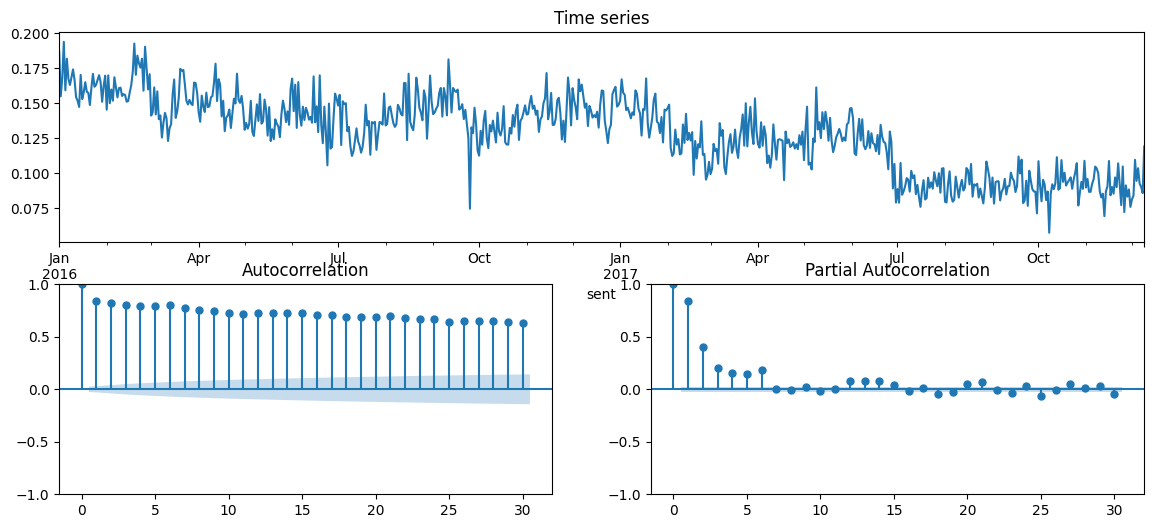

In [63]:
df = pd.read_csv('slack_data_pol.csv', sep=',', index_col=0, parse_dates=True, infer_datetime_format=True)
print(f'First: {df.head(1)} \n Last: {df.tail(1)}')
df['CompoundPol'] = df['CompoundPol'].astype(float)
df = df['CompoundPol'].last('2Y')
df = df.asfreq('D', 'bfill')
tsplot(df, lags=30)
df_days = df.copy()

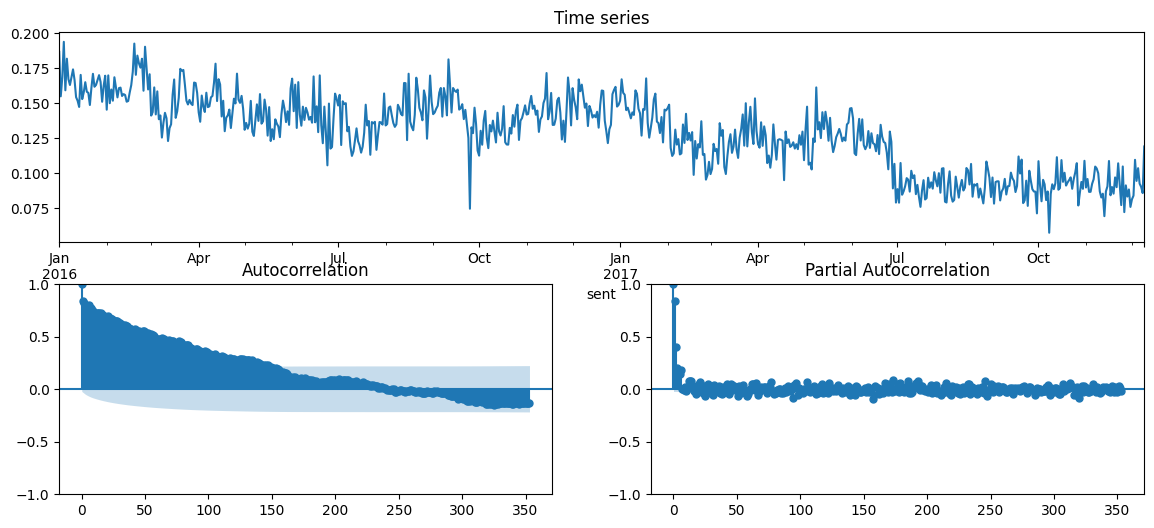

In [64]:
tsplot(df, lags=353)

# Differencování
Zkusíme vykreslit graf po prvním diferencováním. Vypadá to, že jsme se zbavili trendu v datech. PACF v první lagu už není blízké 1.


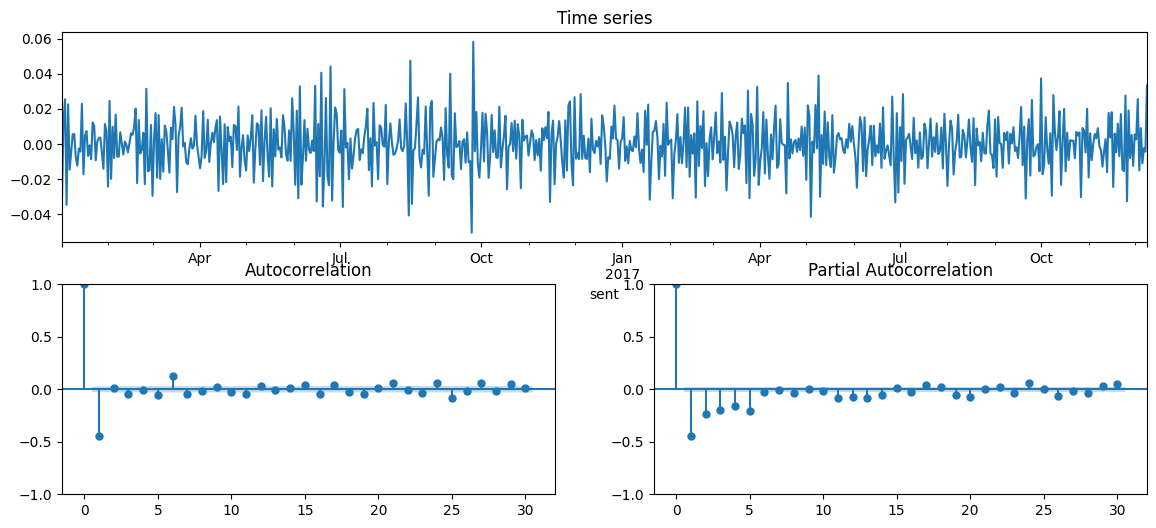

In [65]:
df_d1 = df_days.diff().dropna()
df_d2 = df_d1.diff().dropna()
tsplot(df_d1, lags=30)
#tsplot(df_d1, lags=30)

# Model
Jelikož jsme detekovali trend v datech, využijeme model ARIMA. Pomocí balíčku pmdarima zjístíme nejlepší hodnoty koeficientů p a q. Diferencovat zde bude $1 \times$

In [66]:
stepwise_fit = pm.auto_arima(df_days, start_p=1, start_q=1,
                             max_p=5, max_q=5, m=1,
                             start_P=0, seasonal=False,
                             d=1, trace=True,
                             information_criterion='aic',
                             stepwise=True)               

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4245.340, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3974.313, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4131.251, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4242.117, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3976.282, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4235.357, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4240.718, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4244.466, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4170.869, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4220.058, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4246.179, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4243.284, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4133.170, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4246.693, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0

                               SARIMAX Results                                
Dep. Variable:            CompoundPol   No. Observations:                  709
Model:                 ARIMA(1, 1, 2)   Log Likelihood                2127.421
Date:                Fri, 09 Dec 2022   AIC                          -4246.842
Time:                        13:43:14   BIC                          -4228.592
Sample:                    01-01-2016   HQIC                         -4239.791
                         - 12-09-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7876      0.135      5.813      0.000       0.522       1.053
ma.L1         -1.4968      0.153     -9.766      0.000      -1.797      -1.196
ma.L2          0.5328      0.126      4.226      0.0

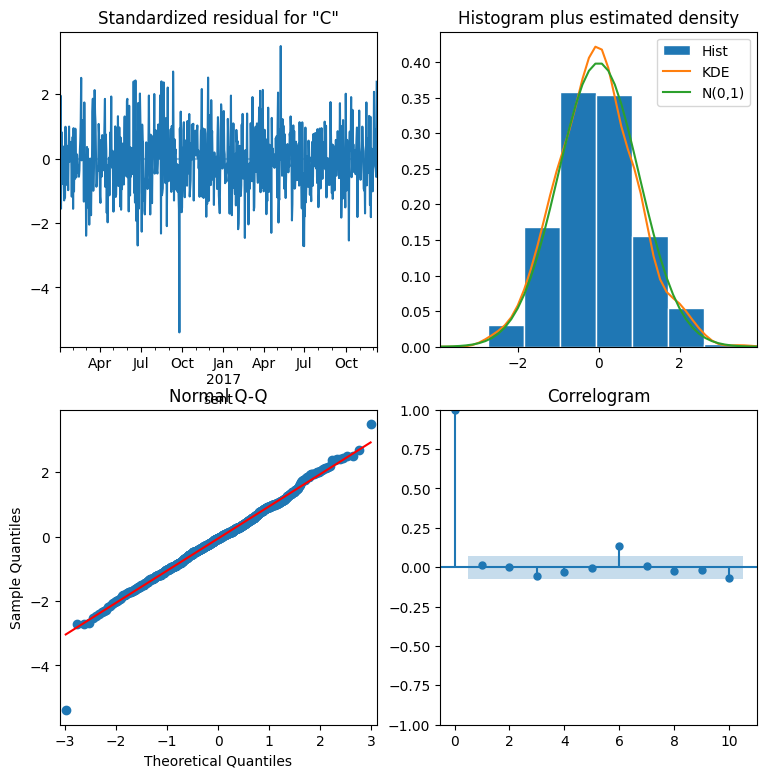

In [67]:
model = ARIMA(df_days, order=(1,1,2), trend='n')
result = model.fit()
print(result.summary())
result.plot_diagnostics(figsize=(9,9))
plt.show()

## Predikce
Diagnostické grafy vypadaly v pořádku, zkusíme teda predikovat budoucí hodnoty.

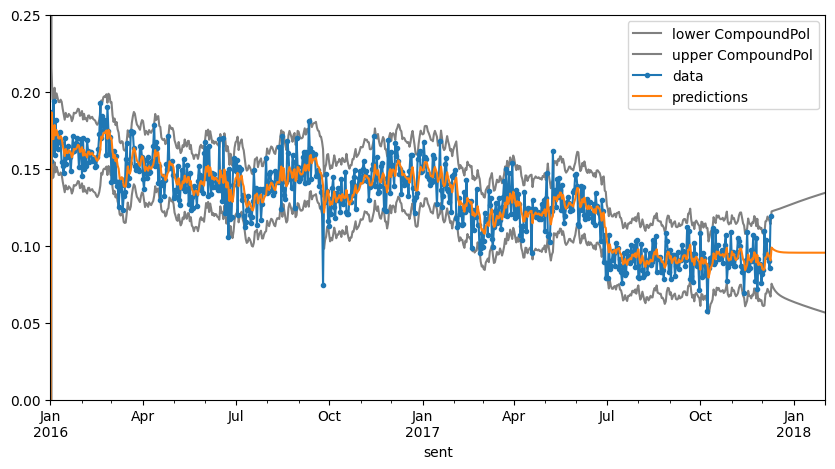

In [68]:
predictions = result.get_prediction(end='2018-02-01')
ci = predictions.conf_int()
fig = ci.plot(color='grey', figsize=(10, 5))
result.data.orig_endog.plot(label='data', marker='.', fig=fig)
predictions.predicted_mean.plot(label='predictions', fig=fig)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

## Predikce na delší dobu

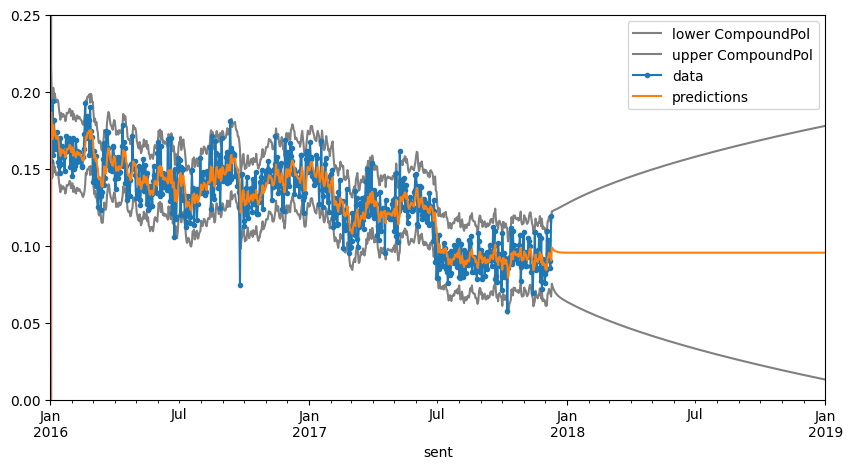

In [69]:
predictions = result.get_prediction(end='2019-01-01')
ci = predictions.conf_int()
fig = ci.plot(color='grey', figsize=(10, 5))
result.data.orig_endog.plot(label='data', marker='.', fig=fig)
predictions.predicted_mean.plot(label='predictions', fig=fig)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

# Dekompozice

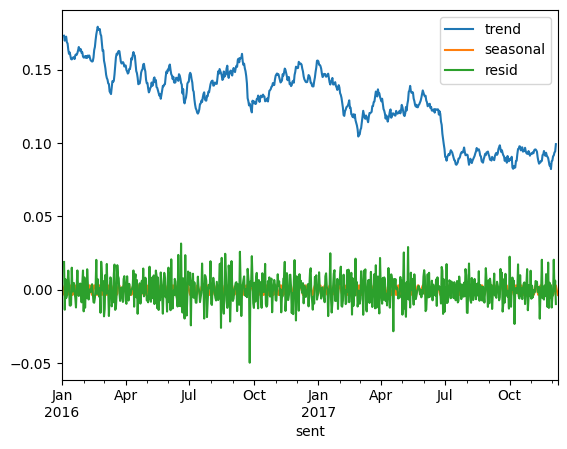

In [70]:
output = seasonal_decompose(df_days, model='aditive')
output.trend.plot()
output.seasonal.plot()
output.resid.plot()
plt.legend()